<a href="https://colab.research.google.com/github/vieirafrancisco/machine-learning-ufal/blob/master/arvores_de_decisao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive

drive.mount('drive')
os.chdir('drive/My Drive/UFAL/machine-learning-ufal/video-game-sales')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


# Imports

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Data

In [186]:
# load data
df = pd.read_csv('data/pre_processed.csv', index_col=False)

# Alguns pré-processamentos

In [187]:
# remover atributos que não vou utilizar
df.drop(['Name', 'Year_of_Release', 'Publisher', 'Critic_Count', 'User_Count'], axis=1, inplace=True)

In [188]:
# critic_score no range 0 a 10
df['Critic_Score'] /= 10

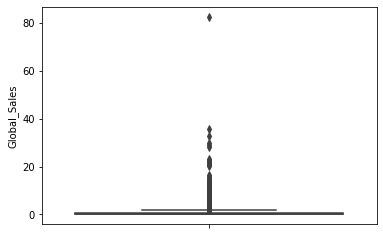

In [189]:
sns.boxplot(y=df['Global_Sales'])

In [190]:
# remover outliers
global_sales = df['Global_Sales']
iqr = global_sales.quantile(.75) - global_sales.quantile(.25)
outliers_index = df[df['Global_Sales'] >= (global_sales.quantile(.75) + 1.5 * iqr)].index
df.drop(index=outliers_index, axis=0, inplace=True)

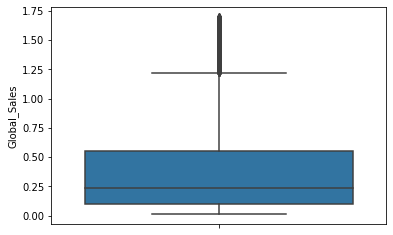

In [191]:
sns.boxplot(y=df['Global_Sales'])

In [192]:
# discretizar atributos categoricos
def discretize(df, attr, inplace=False):
  possible_values = list(df[attr].unique())
  values = list(range(len(possible_values)))
  if inplace:
    df[attr].replace(possible_values, values, inplace=True)
    return
  return df[attr].replace(possible_values, values, inplace=False)

In [193]:
discretize(df, 'Platform', True)
discretize(df, 'Genre', True)
discretize(df, 'Rating', True)

In [194]:
# fazer re-escala min-max
def min_max(df, attr):
  min = df[attr].min()
  max = df[attr].max()
  return [(x-min)/(max-min) for x in df[attr]]
for attr in df.columns:
  df[attr] = min_max(df, attr)

In [195]:
df.head(3)

,Platform,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,User_Score,Rating
692,0.0000,0.000000,0.688623,0.253165,0.000000,0.127119,1.0,0.082353,0.153846,0.0
693,0.0625,0.090909,0.497006,0.379747,0.014388,0.203390,1.0,0.964706,0.868132,0.2
694,0.1250,0.181818,0.844311,0.031646,0.000000,0.194915,1.0,0.870588,0.890110,0.0


# Treino, teste e avaliação

In [233]:
# separar o target dos demais atributos
# 'NA_Sales','EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'
X = df[['Platform', 'Genre', 'Critic_Score', 'User_Score', 'Rating']]
y = df['Global_Sales']

In [234]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [235]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, regressor.predict(X_test))

0.07188244756767051

In [236]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100)
regressor.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [237]:
mean_squared_error(y_test, regressor.predict(X_test))

0.039604136898624534

In [239]:
df['Global_Sales'].describe()

count    6321.000000
mean        0.224379
std         0.230937
min         0.000000
25%         0.053254
50%         0.136095
75%         0.319527
max         1.000000
Name: Global_Sales, dtype: float64